# Multiple Kernel Learning

#### By Saurabh Mahindre - <a href="https://github.com/Saurabh7">github.com/Saurabh7</a>

This notebook is about multiple kernel learning in shogun. We will see how to construct a combined kernel, determine optimal kernel weights using MKL and use it for different types of [classification](http://en.wikipedia.org/wiki/Statistical_classification) and [novelty detection](http://en.wikipedia.org/wiki/Novelty_detection).

1. [Introduction](#Introduction)
2. [Mathematical formulation](#Mathematical-formulation-(skip if you just want code examples))
3. [Using a Combined kernel](#Using-a-Combined-kernel)
4. [Example: Toy Data](#Prediction-on-toy-data)
  1. [Generating Kernel weights](#Generating-Kernel-weights)
5. [Binary classification using MKL](#Binary-classification-using-MKL)
6. [MKL for knowledge discovery](#MKL-for-knowledge-discovery)
7. [Multiclass classification using MKL](#Multiclass-classification-using-MKL)
8. [One-class classification using MKL](#One-class-classification-using-MKL)

In [3]:
import sys
#shogun_path="/home/romain/Downloads/shogun-shogun_6.0.0/build/install/lib/python2.7/dist-packages/"
#shogun_path="/usr/local/lib/python2.7/site-packages/"
shogun_path="/home/global/shogun"
sys.path.append(shogun_path)
print(sys.path)

['', '/home/global/anaconda2/lib/python27.zip', '/home/global/anaconda2/lib/python2.7', '/home/global/anaconda2/lib/python2.7/plat-linux2', '/home/global/anaconda2/lib/python2.7/lib-tk', '/home/global/anaconda2/lib/python2.7/lib-old', '/home/global/anaconda2/lib/python2.7/lib-dynload', '/home/romain/.local/lib/python2.7/site-packages', '/home/global/anaconda2/lib/python2.7/site-packages', '/home/global/anaconda2/lib/python2.7/site-packages/Sphinx-1.5.6-py2.7.egg', '/home/global/anaconda2/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg', '/home/global/anaconda2/lib/python2.7/site-packages/IPython/extensions', '/home/romain/.ipython', '/home/global/shogun', '/home/global/shogun']


In [4]:
%pylab inline
%matplotlib inline
import os
SHOGUN_DATA_DIR=os.getenv('SHOGUN_DATA_DIR', '../../../data')
# import all shogun classes
from modshogun import *

Populating the interactive namespace from numpy and matplotlib


### Introduction

<em>Multiple kernel learning</em> (MKL) is about using a combined kernel i.e. a kernel consisting of a linear combination of arbitrary kernels over different domains. The coefficients or weights of the linear combination can be learned as well.

[Kernel based methods](http://en.wikipedia.org/wiki/Kernel_methods) such as support vector machines (SVMs)  employ a so-called kernel function $k(x_{i},x_{j})$  which intuitively computes the similarity between two examples $x_{i}$ and $x_{j}$. </br>
Selecting the kernel function
$k()$  and it's parameters is an important issue in training. Kernels designed by humans usually capture one aspect of data. Choosing one kernel means to select exactly one such aspect. Which means combining such aspects is often better than selecting.

In shogun the [CMKL](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKL.html) is the base class for MKL. We can do classifications:  [binary](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLClassification.html), [one-class](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLOneClass.html), [multiclass](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLMulticlass.html) and regression too: [regression](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLRegression.html).

### Mathematical formulation (skip if you just want code examples)

</br>In a SVM, defined as:
$$f({\bf x})=\text{sign} \left(\sum_{i=0}^{N-1} \alpha_i k({\bf x}, {\bf x_i})+b\right)$$</br>
where ${\bf x_i},{i = 1,...,N}$ are labeled training examples ($y_i \in {±1}$).

One could make a combination of kernels like:
$${\bf k}(x_i,x_j)=\sum_{k=0}^{K} \beta_k {\bf k_k}(x_i, x_j)$$
where $\beta_k > 0$ and   $\sum_{k=0}^{K} \beta_k = 1$

In the multiple kernel learning problem for binary classification one is given $N$ data points ($x_i, y_i$ )
    ($y_i \in {±1}$), where $x_i$ is translated via $K$ mappings $\phi_k(x) \rightarrow R^{D_k} $, $k=1,...,K$ , from the input into $K$ feature spaces $(\phi_1(x_i),...,\phi_K(x_i))$ where $D_k$ denotes dimensionality of the $k$-th feature space.

In MKL $\alpha_i$,$\beta$ and bias are determined by solving the following optimization program. For details see [1].

$$\mbox{min} \hspace{4mm} \gamma-\sum_{i=1}^N\alpha_i$$
$$ \mbox{w.r.t.} \hspace{4mm}   \gamma\in R, \alpha\in R^N \nonumber$$
$$\mbox {s.t.} \hspace{4mm}  {\bf 0}\leq\alpha\leq{\bf 1}C,\;\;\sum_{i=1}^N \alpha_i y_i=0 \nonumber$$
$$  {\frac{1}{2}\sum_{i,j=1}^N \alpha_i \alpha_j y_i y_j \leq \gamma},  \forall k=1,\ldots,K\nonumber\\
$$


Here C is a pre-specified regularization parameter.
Within shogun this optimization problem is solved using [semi-infinite programming](http://en.wikipedia.org/wiki/Semi-infinite_programming). For 1-norm MKL one of the two approaches described in [1] is used.
The first approach (also called the wrapper algorithm) wraps around a single kernel SVMs, alternatingly solving for $\alpha$ and $\beta$. It is using a traditional SVM to generate new violated constraints and thus requires a single kernel SVM and any of the SVMs contained in shogun can be used. In the MKL step either a linear program is solved via [glpk](http://en.wikipedia.org/wiki/GNU_Linear_Programming_Kit) or cplex or analytically or a newton (for norms>1) step is performed.

The second much faster but also more memory demanding approach performing interleaved optimization, is integrated into the chunking-based [SVMlight](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CSVMLight.html).



### Using a Combined kernel

Shogun provides an easy way to make combination of kernels using the [CombinedKernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CCombinedKernel.html) class, to which we can append any [kernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CKernel.html) from the many options shogun provides. It is especially useful to combine kernels working on different domains and to combine kernels looking at independent features and requires [CombinedFeatures](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CCombinedFeatures.html) to be used. Similarly the CombinedFeatures is used to combine a number of feature objects into a single CombinedFeatures object

In [4]:
kernel = CombinedKernel()

### Prediction on toy data

In order to see the prediction capabilities, let us generate some data using the [GMM](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMM.html) class. The data is sampled by setting means ([GMM notebook](http://www.shogun-toolbox.org/static/notebook/current/GMM.html)) such that it sufficiently covers X-Y grid and is not too easy to classify.

In [5]:
num=30;
num_components=4
means=zeros((num_components, 2))
means[0]=[-1,1]
means[1]=[2,-1.5]
means[2]=[-1,-3]
means[3]=[2,1]

covs=array([[1.0,0.0],[0.0,1.0]])

gmm=GMM(num_components)
[gmm.set_nth_mean(means[i], i) for i in range(num_components)]
[gmm.set_nth_cov(covs,i) for i in range(num_components)]
gmm.set_coef(array([1.0,0.0,0.0,0.0]))
xntr=array([gmm.sample() for i in xrange(num)]).T
xnte=array([gmm.sample() for i in xrange(5000)]).T
gmm.set_coef(array([0.0,1.0,0.0,0.0]))
xntr1=array([gmm.sample() for i in xrange(num)]).T
xnte1=array([gmm.sample() for i in xrange(5000)]).T
gmm.set_coef(array([0.0,0.0,1.0,0.0]))
xptr=array([gmm.sample() for i in xrange(num)]).T
xpte=array([gmm.sample() for i in xrange(5000)]).T
gmm.set_coef(array([0.0,0.0,0.0,1.0]))
xptr1=array([gmm.sample() for i in xrange(num)]).T
xpte1=array([gmm.sample() for i in xrange(5000)]).T
traindata=concatenate((xntr,xntr1,xptr,xptr1), axis=1)
trainlab=concatenate((-ones(2*num), ones(2*num)))

testdata=concatenate((xnte,xnte1,xpte,xpte1), axis=1)
testlab=concatenate((-ones(10000), ones(10000)))

#convert to shogun features and generate labels for data
feats_train=RealFeatures(traindata)  
labels=BinaryLabels(trainlab)         

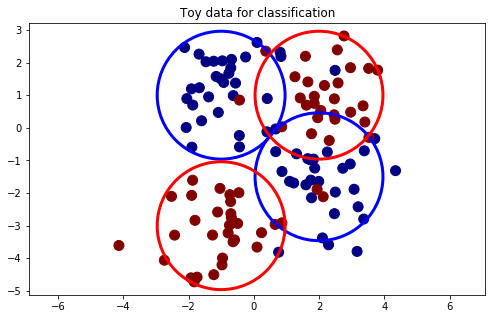

In [6]:
_=jet()
figure(figsize(18,5))
subplot(121)
# plot train data
_=scatter(traindata[0,:], traindata[1,:], c=trainlab, s=100)
title('Toy data for classification')
axis('equal')
colors=["blue","blue","red","red"]
# a tool for visualisation
from matplotlib.patches import Ellipse
def get_gaussian_ellipse_artist(mean, cov, nstd=1.96, color="red", linewidth=3):
    vals, vecs = eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]    
    theta = numpy.degrees(arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * nstd * sqrt(vals)
    e = Ellipse(xy=mean, width=width, height=height, angle=theta, \
               edgecolor=color, fill=False, linewidth=linewidth)
    
    return e
for i in range(num_components):
    gca().add_artist(get_gaussian_ellipse_artist(means[i], covs, color=colors[i]))

### Generating Kernel weights

Just to help us visualize let's use two gaussian kernels ([CGaussianKernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGaussianKernel.html)) with considerably different widths. As required in MKL, we need to append them to the Combined kernel. To generate the optimal weights (i.e $\beta$s in the above equation), training of [MKL](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLClassification.html) is required. This generates the weights as seen in this example.

In [7]:
width0=0.5
kernel0=GaussianKernel(feats_train, feats_train, width0)

width1=25
kernel1=GaussianKernel(feats_train, feats_train, width1)

#combine kernels
kernel.append_kernel(kernel0)   
kernel.append_kernel(kernel1)
kernel.init(feats_train, feats_train)

mkl = MKLClassification()
#set the norm, weights sum to 1.
mkl.set_mkl_norm(1)  
mkl.set_C(1, 1)
mkl.set_kernel(kernel)
mkl.set_labels(labels)

#train to get weights
mkl.train()    

w=kernel.get_subkernel_weights()
print w

[ 0.92865043  0.07134957]


### Binary classification using MKL

Now with the data ready and training done, we can do the binary classification. The weights generated can be intuitively understood. We will see that on plotting individual subkernels outputs and outputs of the MKL classification. To apply on test features, we need to reinitialize the kernel with `kernel.init` and pass the test features. After that it's just a matter of doing  `mkl.apply` to generate outputs. 

/home/global/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:2851: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


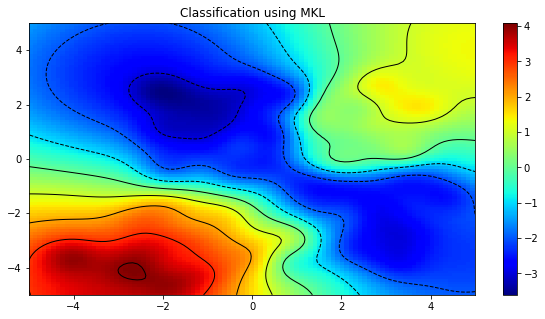

In [8]:
size=100
x1=linspace(-5, 5, size)
x2=linspace(-5, 5, size)
x, y=meshgrid(x1, x2)
#Generate X-Y grid test data
grid=RealFeatures(array((ravel(x), ravel(y))))

kernel0t=GaussianKernel(feats_train, grid, width0)
kernel1t=GaussianKernel(feats_train, grid, width1)

kernelt=CombinedKernel()
kernelt.append_kernel(kernel0t)
kernelt.append_kernel(kernel1t)
#initailize with test grid
kernelt.init(feats_train, grid)

mkl.set_kernel(kernelt)
#prediction
grid_out=mkl.apply()    

z=grid_out.get_values().reshape((size, size))

figure(figsize=(10,5))
title("Classification using MKL")
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)



To justify the weights, let's train and compare two subkernels with the MKL classification output. Training MKL classifier with a single kernel appended to a combined kernel makes no sense and is just like normal single kernel based classification, but let's do it for comparison.

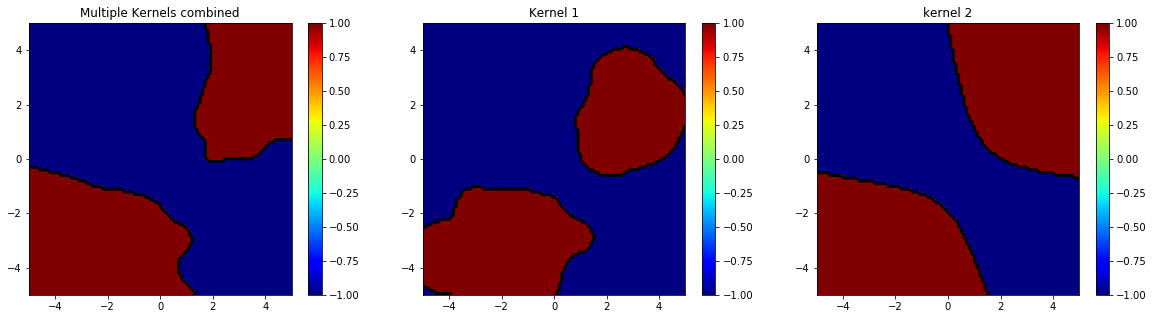

In [9]:
z=grid_out.get_labels().reshape((size, size))

# MKL
figure(figsize=(20,5))
subplot(131, title="Multiple Kernels combined")
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)

comb_ker0=CombinedKernel()
comb_ker0.append_kernel(kernel0)
comb_ker0.init(feats_train, feats_train)
mkl.set_kernel(comb_ker0)
mkl.train()
comb_ker0t=CombinedKernel()
comb_ker0t.append_kernel(kernel0)
comb_ker0t.init(feats_train, grid)
mkl.set_kernel(comb_ker0t)
out0=mkl.apply()

# subkernel 1
z=out0.get_labels().reshape((size, size)) 
subplot(132, title="Kernel 1")
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)

comb_ker1=CombinedKernel()
comb_ker1.append_kernel(kernel1)
comb_ker1.init(feats_train, feats_train)
mkl.set_kernel(comb_ker1)
mkl.train()
comb_ker1t=CombinedKernel()
comb_ker1t.append_kernel(kernel1)
comb_ker1t.init(feats_train, grid)
mkl.set_kernel(comb_ker1t)
out1=mkl.apply()

# subkernel 2
z=out1.get_labels().reshape((size, size))  
subplot(133, title="kernel 2")
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)



As we can see the multiple kernel output seems just about right. Kernel 1 gives a sort of overfitting output while the kernel 2 seems not so accurate. The kernel weights are hence so adjusted to get a refined output. We can have a look at the errors by these subkernels to have more food for thought. Most of the time, the MKL error is lesser as it incorporates aspects of both kernels. One of them is strict while other is lenient, MKL finds a balance between those.

In [10]:
kernelt.init(feats_train, RealFeatures(testdata))
mkl.set_kernel(kernelt)
out=mkl.apply()

evaluator=ErrorRateMeasure()
print "Test error is %2.2f%% :MKL" % (100*evaluator.evaluate(out,BinaryLabels(testlab)))


comb_ker0t.init(feats_train,RealFeatures(testdata)) 
mkl.set_kernel(comb_ker0t)
out=mkl.apply()

evaluator=ErrorRateMeasure()
print "Test error is %2.2f%% :Subkernel1"% (100*evaluator.evaluate(out,BinaryLabels(testlab)))

comb_ker1t.init(feats_train, RealFeatures(testdata))
mkl.set_kernel(comb_ker1t)
out=mkl.apply()

evaluator=ErrorRateMeasure()
print "Test error is %2.2f%% :subkernel2" % (100*evaluator.evaluate(out,BinaryLabels(testlab)))


Test error is 11.58% :MKL
Test error is 19.93% :Subkernel1
Test error is 12.82% :subkernel2


### MKL for knowledge discovery

MKL can recover information about the problem at hand. Let us see this with a binary classification problem. The task is to separate two concentric classes shaped like circles. By varying the distance between the boundary of the circles we can control the separability of the problem. Starting with an almost non-separable scenario, the data quickly becomes separable as the distance between the circles increases.

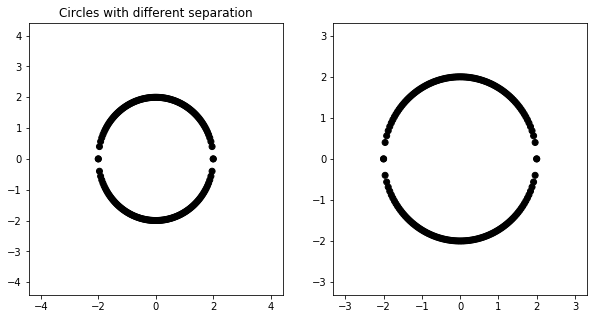

In [5]:
def circle(x, radius, neg):
        y=sqrt(square(radius)-square(x))
        if neg:
            return[x, -y]
        else:
            return [x,y]
        
def get_circle(radius):
    neg=False
    range0=linspace(-radius,radius,100)
    pos_a=array([circle(i, radius, neg) for i in range0]).T
    neg=True
    neg_a=array([circle(i, radius, neg) for i in range0]).T
    c=concatenate((neg_a,pos_a), axis=1)
    return c

def get_data(r1, r2):
    c1=get_circle(r1)
    c2=get_circle(r2)
    c=concatenate((c1, c2), axis=1)
    feats_tr=RealFeatures(c)
    return c, feats_tr

l=concatenate((-ones(200),ones(200)))
lab=BinaryLabels(l)

#get two circles with radius 2 and 4
c, feats_tr=get_data(2,4)
c1, feats_tr1=get_data(2,3)
_=gray()
figure(figsize=(10,5))
subplot(121)
title("Circles with different separation")
p=scatter(c[0,:], c[1,:], c=lab)
subplot(122)
q=scatter(c1[0,:], c1[1,:], c=lab)


These are the type of circles we want to distinguish between. We can try classification with a constant separation between the circles first.

[  3.70950371e-05   6.13400940e-01   3.84762085e-01   1.79988016e-03]


/home/global/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:2851: MatplotlibDeprecationWarning: The 'hold' keyword argument is deprecated since 2.0.
  mplDeprecation)


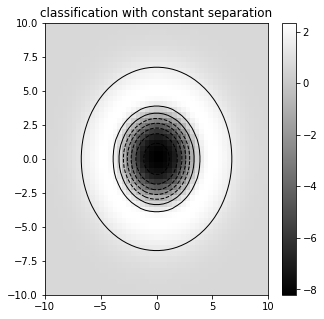

In [6]:
def train_mkl(circles, feats_tr):
    #Four kernels with different widths 
    kernel0=GaussianKernel(feats_tr, feats_tr, 1)  
    kernel1=GaussianKernel(feats_tr, feats_tr, 5)
    kernel2=GaussianKernel(feats_tr, feats_tr, 7)
    kernel3=GaussianKernel(feats_tr, feats_tr, 10)
    kernel = CombinedKernel()
    kernel.append_kernel(kernel0)
    kernel.append_kernel(kernel1)
    kernel.append_kernel(kernel2)
    kernel.append_kernel(kernel3)
    
    kernel.init(feats_tr, feats_tr)
    mkl = MKLClassification()
    mkl.set_mkl_norm(1)
    mkl.set_C(1, 1)
    mkl.set_kernel(kernel)
    mkl.set_labels(lab)
    
    mkl.train()
    
    w=kernel.get_subkernel_weights()
    return w, mkl

def test_mkl(mkl, grid):
    kernel0t=GaussianKernel(feats_tr, grid, 1)
    kernel1t=GaussianKernel(feats_tr, grid, 5)
    kernel2t=GaussianKernel(feats_tr, grid, 7)
    kernel3t=GaussianKernel(feats_tr, grid, 10)
    kernelt = CombinedKernel()
    kernelt.append_kernel(kernel0t)
    kernelt.append_kernel(kernel1t)
    kernelt.append_kernel(kernel2t)
    kernelt.append_kernel(kernel3t)
    kernelt.init(feats_tr, grid)
    mkl.set_kernel(kernelt)
    out=mkl.apply()
    return out

size=50
x1=linspace(-10, 10, size)
x2=linspace(-10, 10, size)
x, y=meshgrid(x1, x2)
grid=RealFeatures(array((ravel(x), ravel(y))))


w, mkl=train_mkl(c, feats_tr)
print w
out=test_mkl(mkl,grid)

z=out.get_values().reshape((size, size))

figure(figsize=(5,5))
c=pcolor(x, y, z)
_=contour(x, y, z, linewidths=1, colors='black', hold=True)
title('classification with constant separation')
_=colorbar(c)

As we can see the MKL classifier classifies them as expected. Now let's vary the separation and see how it affects the weights.The choice of the kernel width of the Gaussian kernel used for classification is expected to depend on the separation distance of the learning problem. An increased distance between the circles will correspond to a larger optimal kernel width. This effect should be visible in the results of the MKL, where we used MKL-SVMs with four kernels with different widths (1,5,7,10). 

In [7]:
range1=linspace(5.5,7.5,50)
x=linspace(1.5,3.5,50)
temp=[]

for i in range1:
    #vary separation between circles
    c, feats=get_data(4,i) 
    w, mkl=train_mkl(c, feats)
    temp.append(w)
y=array([temp[i] for i in range(0,50)]).T


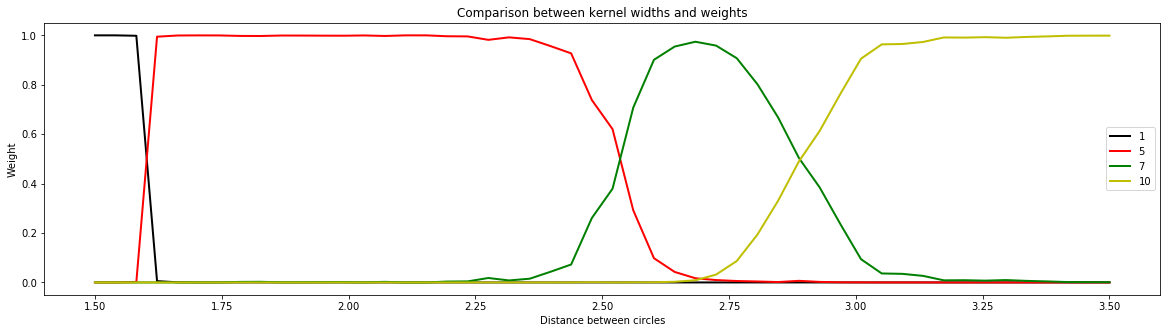

In [8]:
figure(figsize=(20,5))
_=plot(x, y[0,:], color='k', linewidth=2)
_=plot(x, y[1,:], color='r', linewidth=2)
_=plot(x, y[2,:], color='g', linewidth=2)
_=plot(x, y[3,:], color='y', linewidth=2)
title("Comparison between kernel widths and weights")
ylabel("Weight")
xlabel("Distance between circles")
_=legend(["1","5","7","10"])
 

In the above plot we see the kernel weightings obtained for the four kernels. Every line shows one weighting. The courses of the kernel weightings reflect the development of the learning problem: as long as the problem is difficult the best separation can be obtained when using the kernel with smallest width. The low width kernel looses importance when the distance between the circle increases and larger kernel widths obtain a larger weight in MKL. Increasing the distance between the circles, kernels with greater widths are used. 

### Multiclass classification using MKL

MKL can be used for multiclass classification using the [MKLMulticlass](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLMulticlass.html) class. It is based on the GMNPSVM Multiclass SVM. Its termination criterion is set by  `set_mkl_epsilon(float64_t eps )` and the maximal number of MKL iterations is set by `set_max_num_mkliters(int32_t maxnum)`. The epsilon termination criterion is the L2 norm between the current MKL weights and their counterpart from the previous iteration. We set it to 0.001 as we want pretty accurate weights.

To see this in action let us compare it to the normal [GMNPSVM](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGMNPSVM.html) example as in the [KNN notebook](http://www.shogun-toolbox.org/static/notebook/current/KNN.html#Comparison-to-Multiclass-Support-Vector-Machines), just to see how MKL fares in object recognition. We use the  [USPS digit recognition dataset](http://www.gaussianprocess.org/gpml/data/).

In [4]:
from scipy.io import loadmat, savemat
from os       import path, sep

mat  = loadmat(sep.join(['..','..','..','data','multiclass', 'usps.mat']))
Xall = mat['data']
Yall = array(mat['label'].squeeze(), dtype=double)

# map from 1..10 to 0..9, since shogun
# requires multiclass labels to be
# 0, 1, ..., K-1
Yall = Yall - 1

random.seed(0)

subset = random.permutation(len(Yall))

#get first 1000 examples
Xtrain = Xall[:, subset[:1000]]
Ytrain = Yall[subset[:1000]]

Nsplit = 2
all_ks = range(1, 21)

print Xall.shape
print Xtrain.shape

IOError: [Errno 2] No such file or directory: '../../../data/multiclass/usps.mat'

Let's plot five of the  examples to get a feel of the dataset.

In [ ]:
def plot_example(dat, lab):
    for i in xrange(5):
        ax=subplot(1,5,i+1)
        title(int(lab[i]))
        ax.imshow(dat[:,i].reshape((16,16)), interpolation='nearest')
        ax.set_xticks([])
        ax.set_yticks([])
        
        
_=figure(figsize=(17,6))
gray()
plot_example(Xtrain, Ytrain)


We combine a [Gaussian kernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CGaussianKernel.html) and a [PolyKernel](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CPolyKernel.html). To test, examples not included in training data are used.

This is just a demonstration but we can see here how MKL is working behind the scene. What we have is two kernels with significantly different properties. The gaussian kernel defines a function space that is a lot larger than that of the linear kernel or the polynomial kernel. The gaussian kernel has a low width, so it will be able to represent more and more complex relationships between the training data. But it requires enough data to train on. The number of training examples here is 1000, which seems a bit less as total examples are 10000. We hope the polynomial kernel can counter this problem, since it will fit the polynomial for you using a lot less data than the squared exponential. The kernel weights are printed below to add some insight.

In [ ]:
# MKL training and output
labels = MulticlassLabels(Ytrain)
feats  = RealFeatures(Xtrain)
#get test data from 5500 onwards
Xrem=Xall[:,subset[5500:]]
Yrem=Yall[subset[5500:]]

#test features not used in training
feats_rem=RealFeatures(Xrem)             
labels_rem=MulticlassLabels(Yrem)

kernel = CombinedKernel()
feats_train = CombinedFeatures()
feats_test = CombinedFeatures()

#append gaussian kernel
subkernel = GaussianKernel(10,15)        
feats_train.append_feature_obj(feats)
feats_test.append_feature_obj(feats_rem)
kernel.append_kernel(subkernel)

#append PolyKernel
feats  = RealFeatures(Xtrain)
subkernel = PolyKernel(10,2)            
feats_train.append_feature_obj(feats)
feats_test.append_feature_obj(feats_rem)
kernel.append_kernel(subkernel)

kernel.init(feats_train, feats_train)

mkl = MKLMulticlass(1.2, kernel, labels)

mkl.set_epsilon(1e-2)
mkl.set_mkl_epsilon(0.001)
mkl.set_mkl_norm(1)

mkl.train()

#initialize with test features
kernel.init(feats_train, feats_test)     

out =  mkl.apply()
evaluator = MulticlassAccuracy()
accuracy = evaluator.evaluate(out, labels_rem)
print "Accuracy = %2.2f%%" % (100*accuracy)

idx=where(out.get_labels() != Yrem)[0]
Xbad=Xrem[:,idx]
Ybad=Yrem[idx]
_=figure(figsize=(17,6))
gray()
plot_example(Xbad, Ybad)

In [ ]:
w=kernel.get_subkernel_weights()
print w

In [ ]:
# Single kernel:PolyKernel
C=1

pk=PolyKernel(10,2) 

svm=GMNPSVM(C, pk, labels)
_=svm.train(feats)
out=svm.apply(feats_rem)
evaluator = MulticlassAccuracy()
accuracy = evaluator.evaluate(out, labels_rem)

print "Accuracy = %2.2f%%" % (100*accuracy)

idx=np.where(out.get_labels() != Yrem)[0]
Xbad=Xrem[:,idx]
Ybad=Yrem[idx]
_=figure(figsize=(17,6))
gray()
plot_example(Xbad, Ybad)

In [ ]:
#Single Kernel:Gaussian kernel
width=15
C=1

gk=GaussianKernel()
gk.set_width(width)

svm=GMNPSVM(C, gk, labels)
_=svm.train(feats)
out=svm.apply(feats_rem)
evaluator = MulticlassAccuracy()
accuracy = evaluator.evaluate(out, labels_rem)

print "Accuracy = %2.2f%%" % (100*accuracy)

idx=np.where(out.get_labels() != Yrem)[0]
Xbad=Xrem[:,idx]
Ybad=Yrem[idx]
_=figure(figsize=(17,6))
gray()
plot_example(Xbad, Ybad)

The misclassified examples are surely pretty tough to predict. As seen from the accuracy MKL seems to work a shade better in the case. One could try this out with more and different types of kernels too.

### One-class classification using MKL

[One-class classification](http://en.wikipedia.org/wiki/One-class_classification) can be done using MKL in shogun. This is demonstrated in the following simple example using [CMKLOneClass](http://www.shogun-toolbox.org/doc/en/latest/classshogun_1_1CMKLOneClass.html). We will see how abnormal data is detected. This is also known as novelty detection. Below we generate some toy data and initialize combined kernels and features.

In [ ]:
X = -0.3 * random.randn(100,2)
traindata=r_[X + 2, X - 2].T

X = -0.3 * random.randn(20, 2)
testdata = r_[X + 2, X - 2].T

trainlab=concatenate((ones(99),-ones(1)))
#convert to shogun features and generate labels for data
feats=RealFeatures(traindata) 
labels=BinaryLabels(trainlab)         

In [ ]:
xx, yy = meshgrid(linspace(-5, 5, 500), linspace(-5, 5, 500))
grid=RealFeatures(array((ravel(xx), ravel(yy))))
#test features
feats_t=RealFeatures(testdata)   
x_out=(random.uniform(low=-4, high=4, size=(20, 2))).T
feats_out=RealFeatures(x_out)

kernel=CombinedKernel()
feats_train=CombinedFeatures()
feats_test=CombinedFeatures()
feats_test_out=CombinedFeatures()
feats_grid=CombinedFeatures()

#append gaussian kernel
subkernel=GaussianKernel(10,8)        
feats_train.append_feature_obj(feats)
feats_test.append_feature_obj(feats_t)
feats_test_out.append_feature_obj(feats_out)
feats_grid.append_feature_obj(grid)
kernel.append_kernel(subkernel)

#append PolyKernel
feats  = RealFeatures(traindata)
subkernel = PolyKernel(10,3)            
feats_train.append_feature_obj(feats)
feats_test.append_feature_obj(feats_t)
feats_test_out.append_feature_obj(feats_out)
feats_grid.append_feature_obj(grid)
kernel.append_kernel(subkernel)

kernel.init(feats_train, feats_train)

mkl = MKLOneClass()
mkl.set_kernel(kernel)
mkl.set_labels(labels)
mkl.set_interleaved_optimization_enabled(False)

mkl.set_epsilon(1e-2)
mkl.set_mkl_epsilon(0.1)
mkl.set_mkl_norm(1)

Now that everything is initialized, let's see MKLOneclass in action by applying it on the test data and on the X-Y grid.

In [ ]:
mkl.train()
print "Weights:"
w=kernel.get_subkernel_weights()
print w

#initialize with test features
kernel.init(feats_train, feats_test)     
normal_out =  mkl.apply()

#test on abnormally generated data
kernel.init(feats_train, feats_test_out)     
abnormal_out =  mkl.apply()

#test on X-Y grid
kernel.init(feats_train, feats_grid)
grid_out=mkl.apply()
z=grid_out.get_values().reshape((500,500))
z_lab=grid_out.get_labels().reshape((500,500))

a=abnormal_out.get_labels()
n=normal_out.get_labels()

#check for normal and abnormal classified data
idx=where(normal_out.get_labels() != 1)[0]
abnormal=testdata[:,idx]

idx=where(normal_out.get_labels() == 1)[0]
normal=testdata[:,idx]

figure(figsize(15,6))
pl =subplot(121)
title("One-class classification using MKL")
_=pink()
c=pcolor(xx, yy, z)
_=contour(xx, yy, z_lab, linewidths=1, colors='black', hold=True)
_=colorbar(c)
p1=pl.scatter(traindata[0, :], traindata[1,:], cmap=gray(), s=100)
p2=pl.scatter(normal[0,:], normal[1,:], c="red", s=100)
p3=pl.scatter(abnormal[0,:], abnormal[1,:], c="blue", s=100)
p4=pl.scatter(x_out[0,:], x_out[1,:], c=a, cmap=jet(),  s=100)
_=pl.legend((p1, p2, p3), ["Training samples", "normal samples", "abnormal samples"], loc=2)



subplot(122)
c=pcolor(xx, yy, z)
title("One-class classification output")
_=gray()
_=contour(xx, yy, z, linewidths=1, colors='black', hold=True)
_=colorbar(c)



MKL one-class classification will give you a bit more flexibility compared to normal classifications. The kernel weights are expected to be more or less similar here since the training data is not overly complicated or too easy, which means both the gaussian and polynomial kernel will be involved. If you don't know the nature of the training data and lot of features are invoved, you could easily use kernels with much different properties and benefit from their combination.

### References:

[1] Soeren Sonnenburg, Gunnar Raetsch, Christin Schaefer, and Bernhard Schoelkopf. Large Scale Multiple Kernel Learning. Journal of Machine Learning Research, 7:1531-1565, July 2006.

[2]F. R. Bach, G. R. G. Lanckriet, and M. I. Jordan. Multiple kernel learning, conic duality, and
the SMO algorithm. In C. E. Brodley, editor, Twenty-first international conference on Machine
learning. ACM, 2004

[3] Kernel Methods for Object Recognition , Christoph H. Lampert